In [17]:
from __future__ import print_function

import pandas as pd
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [18]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

#  Читаем данные из файла, делает табличную визуализацию

In [19]:
data=pd.read_csv("WAG_C_M.csv",sep=",",index_col=['month'], parse_dates=['month'], dayfirst=True)

In [20]:
data.head(2)

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1


In [21]:
print data.shape

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-21-d73eb330053c>, line 1)

# 1. Построим график временного ряда:

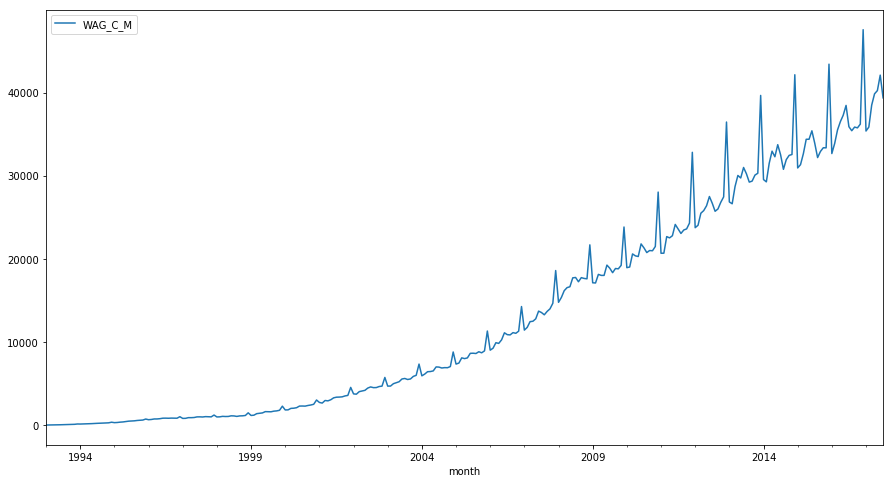

In [22]:
plt.figure(figsize(15,8))
data.plot()

### При визуальном анализе видим следующее:
 1) Выделяется растущий тренд
 2) Четко выделяются сезонные колебания с периодом 12 месяцев
 3) Визуально не наблюдаются циклы
 4) Предположительно, случайная компонента ("щум", "ошибка") в данном датасете мала

In [23]:
from scipy import stats
import statsmodels.api as sm

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 2. Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.270826
Критерий Дики-Фуллера: p=0.755371


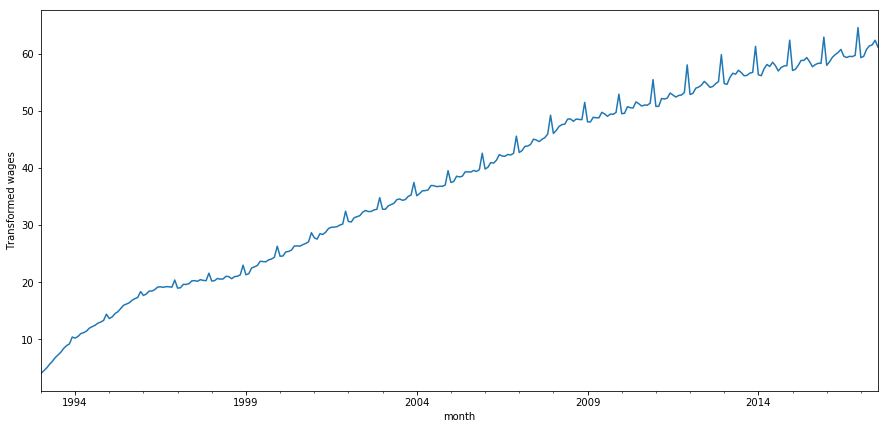

In [24]:
data['WAG_C_M_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.WAG_C_M_box.plot()
plt.ylabel(u'Transformed wages')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box)[1])

# 3. Выбираем порядок дифференцирования

Критерий Дики-Фуллера: p=0.755371


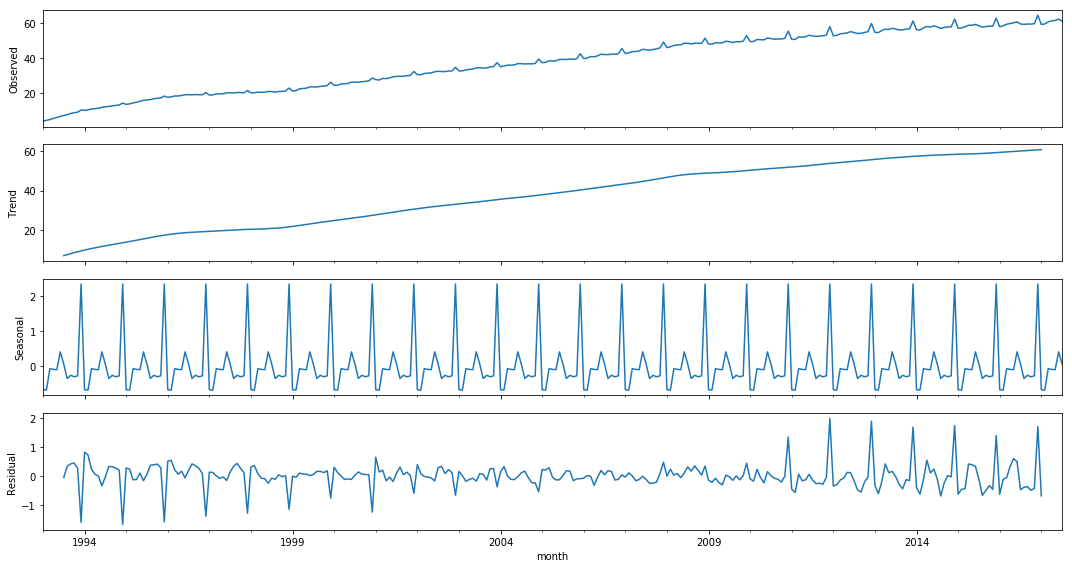

In [25]:
plt.figure(figsize(15,8))
(sm.tsa.seasonal_decompose(data.WAG_C_M_box)).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box)[1])

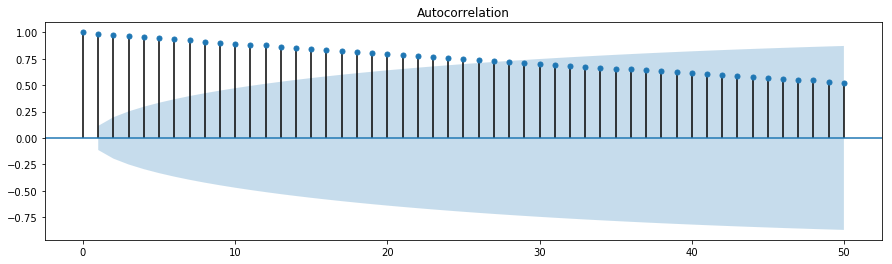

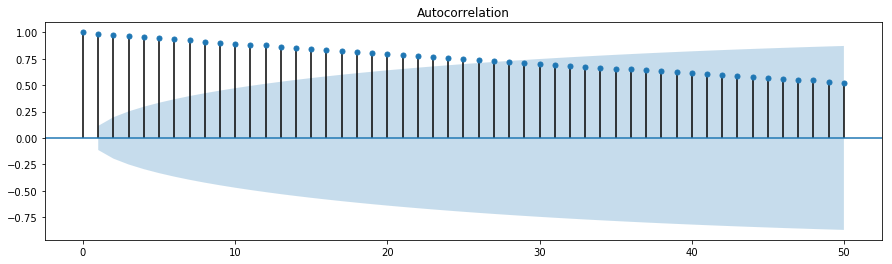

In [26]:
import statsmodels.api as sm
plt.figure(figsize(15,4))
sm.graphics.tsa.plot_acf(((data.WAG_C_M_box).iloc[0:]).squeeze(), lags=50)

In [27]:
data["daily_diff1"] = 0.0
data["daily_diff12"] = 0.0
data["daily_diff1"] = data.WAG_C_M_box - data.WAG_C_M_box.shift(1)
data["daily_diff12"] = data.WAG_C_M_box - data.WAG_C_M_box.shift(12)
data["daily_diff112"] = data.daily_diff1 - data.daily_diff1.shift(12)

In [28]:
data.head(14)

,WAG_C_M,WAG_C_M_box,daily_diff1,daily_diff12,daily_diff112
month,,,,,
1993-01-01,15.3,4.037157,NaN,NaN,NaN
1993-02-01,19.1,4.515774,0.478617,NaN,NaN
1993-03-01,23.6,4.999800,0.484026,NaN,NaN
1993-04-01,30.6,5.633301,0.633501,NaN,NaN
1993-05-01,37.5,6.161273,0.527972,NaN,NaN
1993-06-01,47.4,6.806745,0.645472,NaN,NaN
1993-07-01,56.0,7.291698,0.484953,NaN,NaN
1993-08-01,65.4,7.763133,0.471435,NaN,NaN
1993-09-01,80.9,8.442376,0.679243,NaN,NaN


In [29]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller((data.daily_diff1).iloc[1:])[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller((data.daily_diff12).iloc[12:])[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller((data.daily_diff112).iloc[13:])[1])


Критерий Дики-Фуллера: p=0.007740
Критерий Дики-Фуллера: p=0.007547
Критерий Дики-Фуллера: p=0.000000


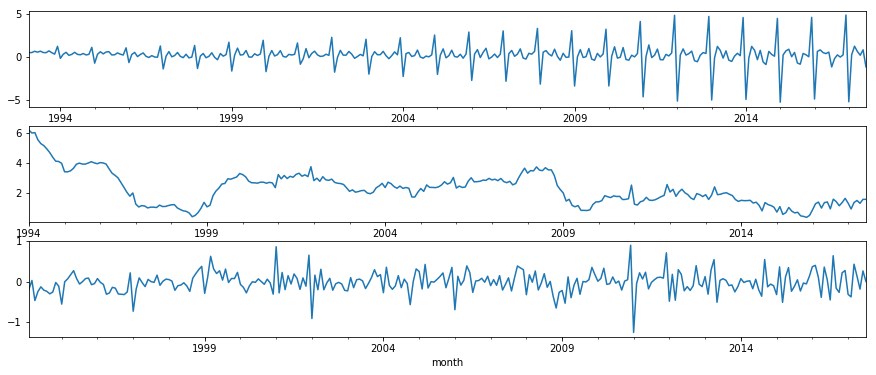

In [30]:
plt.figure(figsize(15,6))
pyplot.subplot(3, 1, 1)
((data.daily_diff1).iloc[1:]).plot()
pyplot.subplot(3, 1, 2)
((data.daily_diff12).iloc[12:]).plot()
pyplot.subplot(3, 1, 3)
((data.daily_diff112).iloc[13:]).plot()

In [31]:
# Model parameters:
d=1
D=1

# 4. Выбор начальных приближений для p,q,P,Q

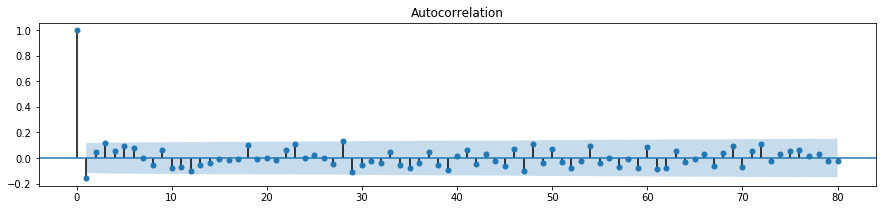

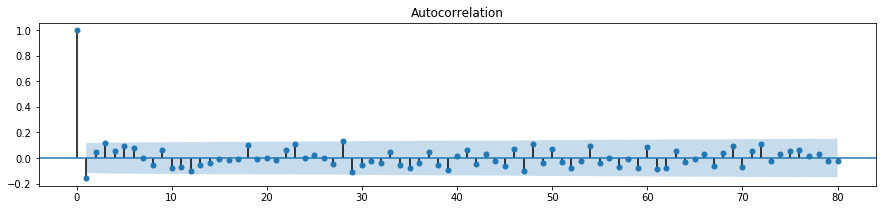

In [32]:
import statsmodels.api as sm
plt.figure(figsize(15,3))
sm.graphics.tsa.plot_acf(((data.daily_diff112).iloc[13:]).squeeze(), lags=80)

In [33]:
# Model parameters:
Q=0
q=1

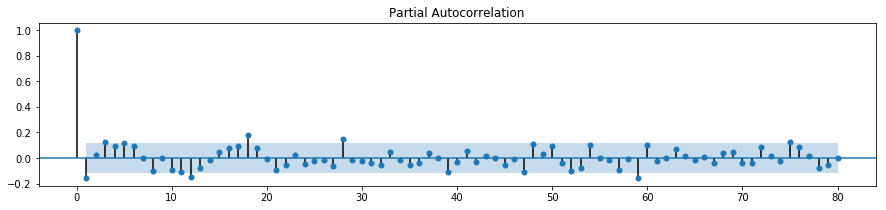

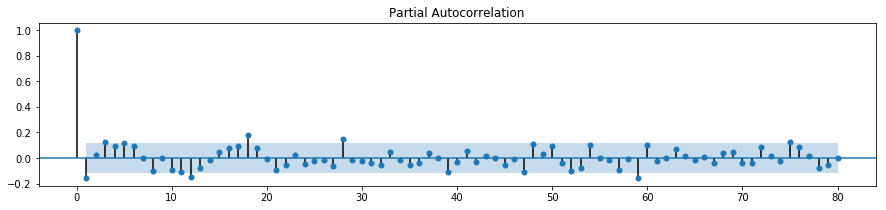

In [34]:
sm.graphics.tsa.plot_pacf(((data.daily_diff112).iloc[13:]).squeeze(), lags=80)

In [35]:
# Model parameters:
P=1
p=1

Для модели используем следующий набор параметров:
d=1
D=1
Q=0
q=1
P=1
p=1

# 5. Обучение  модели
Мета-параметры модели очевидны, их значения малы, попробуем построить модель БЕЗ подбора параметров

In [38]:
model=sm.tsa.statespace.SARIMAX((data.WAG_C_M_box).iloc[0:], order=(p, d, q), 
                                        seasonal_order=(P, D, Q, 12)).fit(disp=-1)
aic = model.aic
print(aic)

44.6471022456


In [39]:
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  295
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                 -18.324
Date:                            Fri, 15 Sep 2017   AIC                             44.647
Time:                                    00:42:13   BIC                             59.395
Sample:                                01-01-1993   HQIC                            50.553
                                     - 07-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1883      0.370     -0.508      0.611      -0.914       0.538
ma.L1          0.0122      0.366   

# 6. Анализ остатков построенной модели

Критерий Стьюдента: p=0.152049
Критерий Дики-Фуллера: p=0.000084


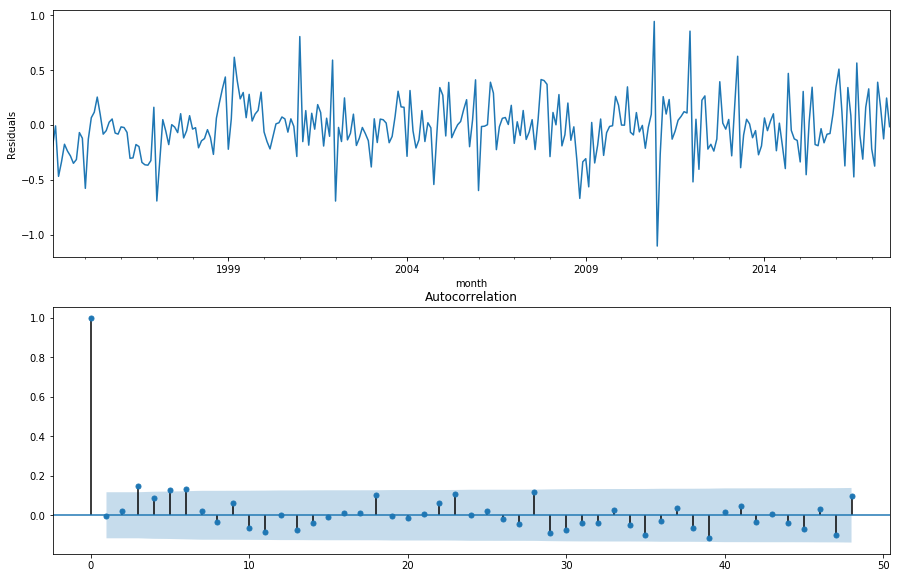

In [40]:
plt.figure(figsize(15,10))
plt.subplot(211)
model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(model.resid[13:])[1])

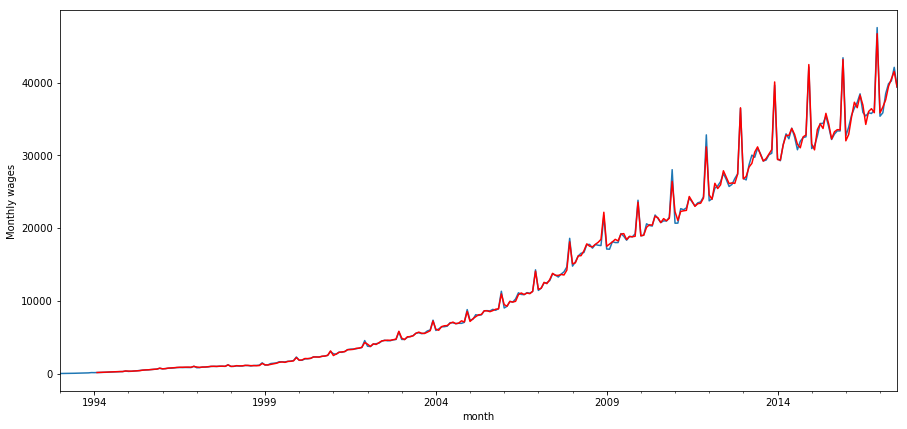

In [41]:
data['model'] = invboxcox(model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('Monthly wages')
pylab.show()

In [42]:
#print data.iloc[270:]

# 7. Прогнозирование с помощью финальной модели.

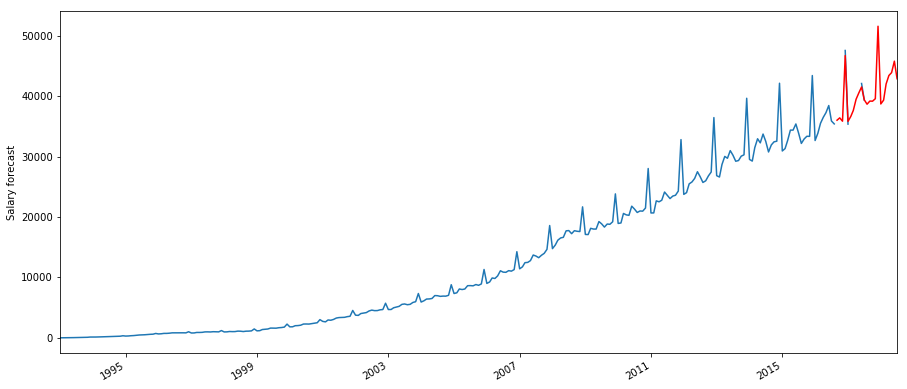

In [43]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(model.predict(start=284, end=316), lmbda)

plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('Salary forecast')
pylab.show()